In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
class CreatingDataStructure():
    def __init__(self, df : pd.DataFrame, filename = "output.json") -> None:
        self.df = df
        self.dict_data = {}
        self.filename = filename
        
        self.df = self.df.set_index("Time") #set index as Time
        
    def loadDict(self):
        for index, info in self.df.iterrows():
            index = pd.to_datetime(index)
            day = str(index.date())
            hour = str(index.hour)
        
        
            #Create nested dictionary if not created already
            if day not in self.dict_data:
                self.dict_data[day] = {}
                
            if hour not in self.dict_data[day]:
                self.dict_data[day][hour] = {}
                
            #Adding each hours data into the nested dict.
            self.dict_data[day][hour][str(index)] = info.to_dict()
        
        # with open(self.filename, 'w') as json_file:
        #     json.dump(self.dict_data, json_file, indent = 4)
        return self.dict_data
            
            
        

#### Creating Training Dictionary

In [3]:
df = pd.read_csv("/Users/anurag/Desktop/Computer Science/Monash/2023/FIT3164 Data Science Project Semester 2/Electricity-Demand-Forecasting/Data/data_for_analysis/actuals_1.csv")
df2 = pd.read_csv("/Users/anurag/Desktop/Computer Science/Monash/2023/FIT3164 Data Science Project Semester 2/Electricity-Demand-Forecasting/Data/data_for_analysis/actuals_2.csv")

#Create Whole Dataset
df = pd.concat([df, df2], axis = 0)

#Creating Data Structure
data_structure = CreatingDataStructure(df)

# Load data into the nested dictionary
train_dict = data_structure.loadDict()

# train_dict

#### Creating Testing Dictionary

In [4]:
df_test = pd.read_csv("/Users/anurag/Desktop/Computer Science/Monash/2023/FIT3164 Data Science Project Semester 2/Electricity-Demand-Forecasting/Data/Forecast_Data/forecasts.csv")

#Creating Data Structure
data_structure_test = CreatingDataStructure(df_test)

# Load data into the nested dictionary
test_dict = data_structure_test.loadDict()

/var/folders/05/dgx_ky6d3n9f_vxn26lcln1h0000gn/T/ipykernel_94222/4285192323.py:11: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  index = pd.to_datetime(index)


#### Function for extracting days from training and test

In [7]:
def extract_days(train_dict, test_dict, start_date):
    
    # Convert the starting date string to a datetime object
    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
    current_date = start_date
    
    # Calculate the ending date by adding 7 days to the starting date
    end_date = start_date + dt.timedelta(7)
    
    training_data = {}
    test_data = {}
    actual_load = {}
    
    for date, _ in train_dict.items():
        if dt.datetime.strptime(date, '%Y-%m-%d') == start_date:
            current_date = dt.datetime.strptime(date, '%Y-%m-%d')

            while current_date <= end_date:
                current_date_str = current_date.strftime('%Y-%m-%d')
                training_data[current_date_str] = train_dict[current_date_str]
                current_date = current_date + dt.timedelta(days=1)
                
        if current_date > end_date:
            
            #first testing day
            final_date_str = end_date.strftime('%Y-%m-%d')
            actual_load[final_date_str] = train_dict[final_date_str]
            test_data[final_date_str] = test_dict[final_date_str]
            
            #second testing day
            end_date = end_date + dt.timedelta(days = 1)
            final_date_str = end_date.strftime('%Y-%m-%d')
            actual_load[final_date_str] = train_dict[final_date_str]
            test_data[final_date_str] = test_dict[final_date_str]
            break
    
    
    return training_data, test_data, actual_load


In [8]:
start_date = '2017-03-18'
filtered_train_data, filtered_test_data, actual_load = extract_days(train_dict, test_dict, start_date)

In [9]:
def organise_attributes_into_lists(data, x = True):
    #x = True if we are using the training set.
    if x == True:
        attributes = {
            'Load (kW)': [],
            'Cloud Cover (%)': [],
            'Pressure_kpa': [],
            'Temperature (C) ': [],
            'Wind Direction (deg)': [],
            'Wind Speed (kmh)': []
        }
    
    else:
        attributes = {
            'Cloud Cover (%)': [],
            'Pressure_kpa': [],
            'Temperature (C) ': [],
            'Wind Direction (deg)': [],
            'Wind Speed (kmh)': []
        }
        

    for day_data in data.values():
        for hourly_data in day_data.values():
            for attribute_data in hourly_data.values():
                # print(attribute_data)
                for attribute, value in attribute_data.items():
                    if attribute in attributes:
                        attributes[attribute].append(value)
    return attributes

In [12]:
# print(filtered_train_data)
# print(filtered_test_data)
# print(actual_load)

In [19]:
def linear_regression_and_evaluation(train_data, test_data, actual_load):
    # Convert attribute lists into DataFrames
    X_train = pd.DataFrame(train_data)
    X_test = pd.DataFrame(test_data)

    # Extract target values
    y_train = X_train['Load (kW)']

    # Remove the target column from attribute DataFrames
    X_train.drop(columns=['Load (kW)'], inplace=True)

    # Create and train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict 'Load (kW)' for the testing data
    predicted_loads = model.predict(X_test)

    print("Predicted Load (kW) for the testing data: \n\n", predicted_loads, "\n\n")

    # Convert the actual values to a NumPy array
    actual_values = np.array(actual_load['Load (kW)'])

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual_values, predicted_loads)
    print("Mean Absolute Error:", mae)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_loads))
    print("Root Mean Squared Error:", rmse)

    # Plot the actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(actual_values, label='Actual Load (kW)')
    plt.plot(predicted_loads, label='Predicted Load (kW)')
    plt.xlabel('Hour')
    plt.ylabel('Load (kW)')
    plt.title('Actual vs. Predicted Load')
    plt.legend()
    plt.show()


Predicted Load (kW) for the testing data: 

 [ 931862.44572132  937955.96161241  933405.06046959  939498.57636069
  987931.33484953  987875.43103402 1036364.09333838 1062613.73510154
 1099451.89008311 1125701.53184627 1157893.84445098 1216930.10482449
 1238478.00039527 1211075.01447132 1210515.97631618 1161468.27585667
 1124335.79152166 1086679.71527239 1049547.23093737 1028537.91594711
 1002329.36772359  991852.66213621 1001693.9681783   985270.82218136
 1006224.23335611 1005832.90664751 1005441.5799389   977626.80973172
 1011535.09583    1071707.83396731 1116204.633284   1132312.99235287
 1159009.86464015 1185706.73692743 1228096.23604194 1259897.22193804
 1291642.30401863 1280606.56027611 1231614.76363211 1193735.07212078
 1156078.99587151 1129535.02475491 1091934.85232115 1061063.59532378
 1045924.18096256 1003884.915017    998015.01438797 1002677.72316182] 


Mean Absolute Error: 72849.89532073057
Root Mean Squared Error: 91987.80957959362


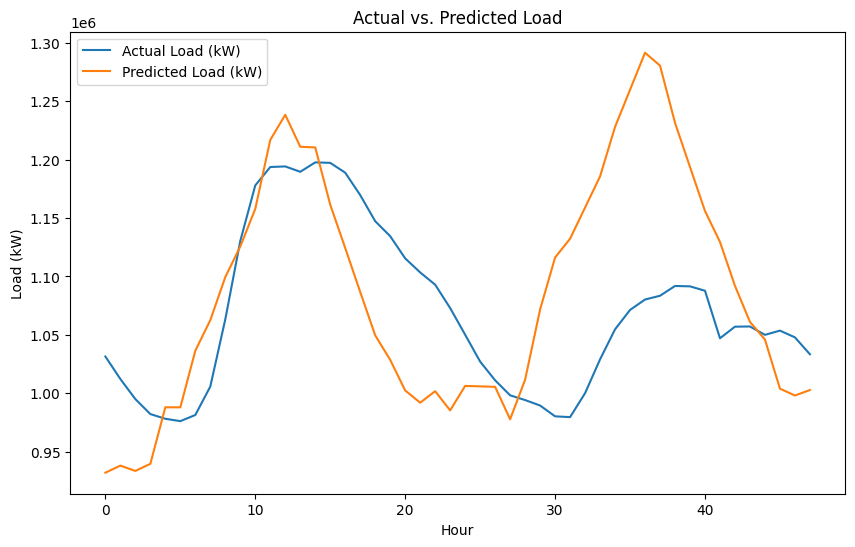

In [20]:
# Use the function to organize attributes into lists
train_attributes = organise_attributes_into_lists(filtered_train_data)
test_attributes = organise_attributes_into_lists(filtered_test_data, False)
actual_load = organise_attributes_into_lists(actual_load)

#Call function
linear_regression_and_evaluation(train_attributes, test_attributes, actual_load)
start_date = '2017-03-18'
filtered_train_data, filtered_test_data, actual_load = extract_days(train_dict, test_dict, start_date)

In [ ]:
#Retraining is basically when new data for the actuals is added we need to use this data on top of the original data. 

#Also normalise the data
#Also save the model because it needs to be LEARNING!
#Make an epoch
#What are examples of Naive, Naive Seasonal, and Randomwalk.

# Look at the book above to understand naive, seasonal naive and random walk.
#https://otexts.com/fpp3/

#For next week:
    #Create Data Structure
    #Create Naive, Seasonal Naive and Random Walk -> Read the book
        #See if there is a reason to look at quarters
            #Check out in R the library forecast
            #OR Checkout in python library Neural Forecast
    #Find the MAE, RMSE and other types of error measures
    #Find other models which we can use and which ones are the best.
    #XGBoost, and other models
    #Learn how to save models
    #See random chosing through the data structure batching.
